# 4 - Hierarchy extraction



In [2]:
%matplotlib inline

import heapq as hq
from collections import defaultdict
from time import time

import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

We first open the dataset, trained cav weights and computed projections. Then we compute the mean projection per concept and store it as a matrix $S$.

In [3]:
playlists = np.load('../data/deezer_playlists.npy', allow_pickle=True).item()
stat_dict = np.load('../results/stats_deezer.npy', allow_pickle=True).item()
training_names = np.load('../weights/deezer_cav.npy', allow_pickle=True)[2]
filtered_cavs = np.load('../results/filtered_cavs_deezer.npy', allow_pickle=True).item()

names = []
last_pid = -1
filtered_idx = []

for k in stat_dict.keys():
    pid = int( k.split('_')[0] )
    if pid == last_pid:
        continue
    last_pid = pid
    if pid in filtered_cavs:
        names.append(pid)
        filtered_idx.append(training_names.index(pid))

# if run on the zenodo dataset, there is only one available pooling layer, refered to as 0, change the following:
studied_pooling_layer = 2  
act = 'sig'  # '' or 'sig'

S = np.zeros((len(names), len(names)))
for i, k in enumerate(names):
    layer_tag = f'{k}_{studied_pooling_layer}'
    S[i,:] = stat_dict[layer_tag][f'e{act}x'][filtered_idx] / stat_dict[layer_tag]['n']

Then we binary $S$ as $A$ that links each concept to what positive sides of other concepts's frontiers it stands on. 

In [4]:
def gen_sim_graph(S, threshold = 0.5):
    similarity = np.copy(S)  # S
    np.fill_diagonal(similarity, np.min(similarity) - 0.1)
    adjacency = similarity > threshold  # A

    return similarity, adjacency

similarity, adjacency = gen_sim_graph(S, 0.5)
print("sparsity : {} (#:{})".format(np.sum(adjacency) / adjacency.shape[0] ** 2, np.sum(adjacency)))


sparsity : 0.11043829094529733 (#:1309163)


## Concept hierarchy extraction

First, we compute the centrality on $A$, or used a cached result because it's a cubic complexity.

In [5]:
USE_CACHE = True

if not USE_CACHE:  # 28 minutes on my computer
    graph = nx.Graph()
    for v in range(adjacency.shape[1]):
        graph.add_node(v)
    for v in range(adjacency.shape[1]):
        for w in range(adjacency.shape[1]):
            if v != w and adjacency[v, w]:
                graph.add_edge(v, w)

    print('computing centrality...')
    start_time = time()
    centrality_vec = nx.centrality.betweenness_centrality(graph)
    print('took', time() - start_time, 'seconds')
    np.save('../results/centrality_deezer', centrality_vec)
    del centrality_vec

deezer_centrality_vec = np.load('../results/centrality/cav_deezer.npy', allow_pickle=True).item()

Apply the Heymann and Garcia-Molina algorithm to convert the similiraty graph into a hierarchy. We have added some contrainsts  to handle some edge-cases that are not detailed in the paper due to the page-limit. For instance, we have added a saturation number for nodes, which can be seen as a way to incorporate a human prior into the expected graph, e.g., you may want to obtain a binary tree. If you do not require a planar graph, you may also find it interesting to try experimenting with having more than one parent per node and having multiple parent influences.

In [6]:
import heapq as hq
from time import time

def heymann(graph, similarity, centrality_vec = {},
            min_sim = 0.2, parents_per_node = 1,
            additional_threshold = 0.2, max_children_per_node = 20):
    '''
    Transforms a graph into a tree hierarchy.
    if centrality is provided, graph will not be used.

    graph: nx graph to use to compute the centrality vec
    similarity: similarity matrix
    std_times_threshold : heymann min threshold to add node not to root
    parents_per_node : add several #link to node, to control sparsity
    additional_threshold : avoids bad links for multiple parents
    max_children_per_node : avoids big cluster of nodes

    return matrix of [parent, children]
    '''
    if len(centrality_vec) == 0:
        print('computing centrality...')
        start_time = time()
        centrality_vec = nx.centrality.betweenness_centrality(graph)
        print('took', time() - start_time, 'seconds')
    sorted_nodes = sorted(centrality_vec.items(), key=lambda el : el[1])[::-1]

    heymann_graph = np.zeros((similarity.shape[1] + 1, similarity.shape[1]))  # + root
    count_nodes = defaultdict(int)
    available_roots = set(['<root>'])
    count_nodes['<root>'] = -1e9

    for i, (node, v) in tqdm(enumerate(sorted_nodes)):
        if i == 0: # solo node
            heymann_graph[-1, node] = True
            continue

        max_heap = [(float('inf'), '<root>')]
        for node_idx, w in sorted_nodes[:i]:  # already added
            if count_nodes[node_idx] >= max_children_per_node:
                continue # max node by node, find something else
            sim = similarity[node_idx, node]  # important not to use the .T of this
            hq.heappush(max_heap, (-sim, node_idx))

        parent_candidates = hq.nsmallest(parents_per_node, max_heap)  # extract top similarities
        max_negsim, max_idx = max_heap[0]
        for negsim, idx in parent_candidates:
            if ((-negsim > min_sim)
                    and (-negsim > -(max_negsim+additional_threshold)) ):
                heymann_graph[idx, node] = True
                count_nodes[idx] += 1
            else:
                heymann_graph[-1, node] = True

    print("heymann sparsity : {} (#:{})".format(np.sum(heymann_graph) / heymann_graph.shape[0] ** 2,  np.sum(heymann_graph)))
    return heymann_graph

heymann_graph = heymann({}, similarity, deezer_centrality_vec, parents_per_node = 1 )

3443it [00:04, 841.99it/s] 


heymann sparsity : 0.00029027573750102856 (#:3443.0)


In [7]:
import matplotlib.cm as cm

def draw_graph(graph, names, figsize=(5, 5)):
    ''' Draw the graph with networkx
    However, I recommend to export to Gephi for a better exploration. It has better and faster layout algorithms.
    '''
    draw_graph = nx.DiGraph()
    trunc_names = [n[:15] for n in names]
    labeldict = {}

    colors_map = cm.rainbow(np.linspace(0, 1, len(graph.nodes)))

    # nodes
    node_colors = []
    for v in graph.nodes:
        draw_graph.add_node(v)
        labeldict[v] = ""
        
    # edges
    for v, w in graph.edges:
        color_to_draw = colors_map[v]
        draw_graph.add_edge(v, w, color = color_to_draw )
    edge_colors = [draw_graph[u][v]['color'] for u, v in draw_graph.edges()]

    # draw
    pos = nx.spring_layout(draw_graph.to_undirected())
    colors_to_draw = colors_map

    plt.figure(figsize=figsize)
    nx.draw(draw_graph, pos,
        labels = labeldict,
        alpha=0.8,
        node_size = 50,
        node_color = colors_to_draw,
        edge_color = edge_colors,
    )

In [8]:
h_graph = nx.Graph()
for v in range(heymann_graph.shape[1]):
    h_graph.add_node(v)
for v in range(heymann_graph.shape[1]):
    for w in range(heymann_graph.shape[1]):
        if v != w and heymann_graph[v, w]:
            h_graph.add_edge(v, w)

titles = [ playlists[pid]['formatted_title'].replace('$','') for pid in names ]

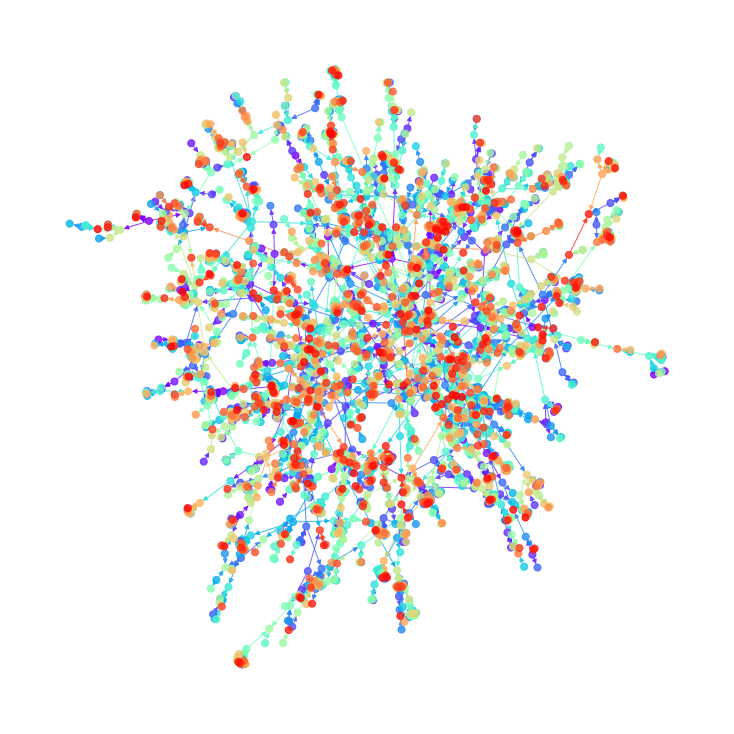

In [9]:
draw_graph(h_graph, titles, figsize=(10, 10))

## Comparison to baseline graphs

In [10]:
def regen_subgraph(idx, S, threshold=0.5):
    """
    Regen graph on only the available subet of nodes
    """
    S_red = S[idx][:, idx]
    return gen_sim_graph(S_red, threshold)


def regen_subhierarchy(idx, S, names, centrality_vec):
    """
    Regen a hierarchy from a subset of nodes
    """
    names_red = np.array(names)[idx]
    centrality_red = {}
    for i, name in enumerate(names_red):
        old_idx = names.index(name)
        centrality_red[i] = centrality_vec[old_idx]

    similarity, _ = regen_subgraph(idx, S)
    heymann_graph = heymann({}, similarity, centrality_red)

    return similarity, heymann_graph


def cosim(A, B):
    ''' <A,B>/|A||B| '''
    na = np.sqrt(A @ A)
    nb = np.sqrt(B @ B)
    if na * nb == 0:
        return 0.
    return (A @ B) / ( na * nb )


def nn_dist(X):
    '''l2 dist matrix'''
    norm = np.sum(np.square(X), -1, keepdims=True)
    return norm + norm.T - 2 * np.dot(X, X.T)


def gen_opt_graph(names, emb, use_cosim = True, threshold = 0.1, gen_graph = False):
    '''
    Generate the similarity graph from embeddings to compute the centrality.
    
    It's unclear what to do exactly as it's not build on CAVs (for which we could have
    a nice reasoning) but latent uninterpretable embeddings. What I will do, very generically:
    - threshold the similarities (l2 or cos-sim) to create the base graph's edges
    - add the top 1 similarities of each node to avoid having unconnected nodes and being
      able to compute centrality measure for all nodes.
    Since the important step is the next one with Heymann's computation and this graph is only
    used to compute the centralities, I want to think that the construction of this first
    graph does not hurt too much the performances of the baselines hierarchies.
    
    I'm open to criticisms on how to have better baselines for hierarchies.
    '''
    E = np.stack([emb[pid] for pid in names], 0)
    if use_cosim:
        E = E / np.sqrt(np.sum(np.square(E), 1, keepdims = True))
        similarity = E @ E.T
        np.fill_diagonal(similarity, -1)  # no self-loop
    else:
        similarity = -nn_dist(E)
        np.fill_diagonal(similarity, np.min(similarity) - 0.1)  # no self-loop

    adjacency = np.zeros_like(similarity)
    adjacency = similarity == np.max(similarity, axis = 1, keepdims = True) # min top con
    adjacency = adjacency | ( similarity > threshold) # and add thresholded
    print("sim graph sparsity : {} (#:{})".format(np.sum(adjacency) / adjacency.shape[0] ** 2, np.sum(adjacency)))

    if not gen_graph:
        return adjacency, similarity, None

    graph = nx.Graph()
    for v in range(adjacency.shape[1]):
        graph.add_node(v)
    for v in range(adjacency.shape[1]):
        for w in range(adjacency.shape[1]):
            if v != w and adjacency[v, w]:
                graph.add_edge(v, w)
    return adjacency, similarity, graph


How were below number chosen? Such that they roughtly match the 10% sparsity of the initial graph of CAVs for fair comparison.

In [12]:
USE_CACHE = True

# LLM playlist title embeddings-> warning, LLM has more names than the cav matrix due to filtering retro-compatibilities
emb_llm = np.load('../weights/embeddings/llm.npy', allow_pickle=True).item()
names_llm = list(set(emb_llm.keys()) & set(names))
llm_intersect, llm_similarity, sim_llm_graph = gen_opt_graph(names_llm, emb_llm, threshold = 0.43, gen_graph = USE_CACHE)
if not USE_CACHE:
    llm_centrality_vec = nx.centrality.betweenness_centrality(sim_llm_graph)
    np.save('../results/centrality/llm_deezer', llm_centrality_vec)
llm_centrality_vec = np.load('../results/centrality/llm_deezer.npy', allow_pickle=True).item()


# USG collaborative filtering embeddings on playlist
emb_usg = np.load('../weights/embeddings/usg.npy', allow_pickle=True).item()
names_usageemb = list(set(emb_usg.keys()) & set(names))
usg_intersect, usg_similarity, sim_usg_graph = gen_opt_graph(names_usageemb, emb_usg, use_cosim = False, threshold = -0.8, gen_graph = USE_CACHE)
if not USE_CACHE:
    usg_centrality_vec = nx.centrality.betweenness_centrality(sim_usg_graph)
    np.save('../results/centrality/usg_deezer', usg_centrality_vec)
usg_centrality_vec = np.load('../results/centrality/usg_deezer.npy', allow_pickle=True).item()


# W2V S.DOH playlist title embeddings
emb_w2v_sdoh = np.load('../weights/embeddings/sdoh_w2v.npy', allow_pickle=True).item()
names_w2v_sdoh = list(set(names) & set(emb_w2v_sdoh.keys() ) )
sdoh_intersect, sdoh_similarity, sim_sdoh_graph = gen_opt_graph(names_w2v_sdoh, emb_w2v_sdoh, threshold = 0.68, gen_graph = USE_CACHE)
if not USE_CACHE:
    sdoh_centrality_vec = nx.centrality.betweenness_centrality(sim_sdoh_graph)
    np.save('../results/centrality/sdoh_deezer', sdoh_centrality_vec)
sdoh_centrality_vec = np.load('../results/centrality/sdoh_deezer.npy', allow_pickle=True).item()


# W2V M.WON playlist title embeddings
emb_w2v_mwon = np.load('../weights/embeddings/mwon_w2v.npy', allow_pickle=True).item()
names_w2v_mwon = list(set(names) & set(emb_w2v_mwon.keys() ) )
mwon_intersect, mwon_similarity, sim_mwon_graph = gen_opt_graph(names_w2v_mwon, emb_w2v_mwon, threshold = 0.38, gen_graph = USE_CACHE)
if not USE_CACHE:
    mwon_centrality_vec = nx.centrality.betweenness_centrality(sim_mwon_graph)
    np.save('../results/centrality/mwon_deezer', mwon_centrality_vec)
mwon_centrality_vec = np.load('../results/centrality/mwon_deezer.npy', allow_pickle=True).item()

# AUDIO
weights_np, biases_np, names_cav = np.load('../weights/deezer_cav.npy', allow_pickle = True)
emb_music_tensor = np.concatenate((weights_np[studied_pooling_layer], biases_np[studied_pooling_layer]), 0).T
emb_music = {}
for emb, name in zip(emb_music_tensor, names_cav):
    emb_music[name] = emb

total_inter = list(set(names_llm) & set(names_w2v_mwon) & set(names_w2v_sdoh) & set(names_usageemb))

sim graph sparsity : 0.08199287867160543 (#:971964)
sim graph sparsity : 0.12391401320210348 (#:1406444)
sim graph sparsity : 0.09613974817245087 (#:1088612)
sim graph sparsity : 0.09315100333295362 (#:1010729)


In [13]:
def metric_dist(names, emb, graph, use_cosim = True):
    nei_dist = []
    for node, graph_parent in zip(names, graph.T):
        parents = np.where(graph_parent == 1)[0]
        if parents.shape[0] == 0:
            continue
        for parent in parents:
            if use_cosim:
                diff_sim = cosim(emb[node], emb[names[parent]] )
            else:
                diff_sim = np.sqrt(np.sum(np.square(
                            emb[node] - emb[names[parent]] )))
            nei_dist.append(diff_sim)
    conf_coef = 1.96 / np.sqrt(len(nei_dist))
    return np.mean(nei_dist), np.std(nei_dist), conf_coef * np.std(nei_dist)


def eval_unsupervised_audio(S, names, hierarchy = True, centrality_vec = {}, baseline = -1):
    '''
    Eval on a set of metrics and with different possible baselines.
    '''
    latex_script = ""

    def eval_sub(subnames, subemb, use_cosim=True, emb_name='subgraph'):
        ''' I input subnames instead of computing it to keep track of the
        exact ordered list. '''
        idx = [names.index(el) for el in subnames if el in total_inter]
        filtered_subnames = [el for el in subnames if el in total_inter]
        if hierarchy:
            similarity, subgraph = regen_subhierarchy(idx, S, names, centrality_vec)
            subgraph = subgraph[:-1]
        else:
            if baseline == 1:
                similarity, subgraph = regen_subgraph(idx, S, 0.66)
            elif baseline == 0:  # random graph
                similarity, _ = regen_subgraph(idx, S, 0.1) # just a way to have similarity
                rand_graph = np.random.uniform(0, 1, (len(idx), len(idx)))
                subgraph = rand_graph == np.max(rand_graph, axis = 1, keepdims = True)
            elif baseline == 3:  # random graph
                similarity, _ = regen_subgraph(idx, S, 0.1) # just a way to have similarity
                rand_graph = np.random.uniform(0, 1, (len(idx), len(idx)))
                subgraph = rand_graph > 0.9
            else:
                similarity, subgraph = regen_subgraph(idx, S)

            if baseline == 2:
                subgraph = similarity == np.max(similarity, 1, keepdims = True)

        mean_dist, std_dist, conf_dist = metric_dist(filtered_subnames, subemb, subgraph, use_cosim)
        print( '{}: cosim neighbors {:.4f} ± {:.4f} (std: {:.4f})'.format(
                emb_name, mean_dist, conf_dist, std_dist ) )
        return "\n & {:.3f} $\\pm$ {:.3f}".format( mean_dist, conf_dist )

    latex_script += eval_sub(names, emb_music, use_cosim=False, emb_name='Music')
    latex_script += eval_sub(names_usageemb, emb_usg, use_cosim=False, emb_name='Usage')
    latex_script += eval_sub(names_llm, emb_llm, emb_name='BERT')
    latex_script += eval_sub(names_w2v_mwon, emb_w2v_mwon, emb_name='W2V Won')
    latex_script += eval_sub(names_w2v_sdoh, emb_w2v_sdoh, emb_name='W2V Doh')

    return latex_script


def eval_opt(inclusion, centrality, names):
    ''' Same but without baseline, more straightforward for OPT graphs. '''
    latex_script = ""

    def regen_and_eval(subemb, use_cosim=True, emb_name='subgraph'):
        subnames = list(set(subemb.keys()) & set(names) )
        idx = [names.index(el) for el in subnames if el in total_inter]
        filtered_subnames = [el for el in subnames if el in total_inter]
        subsimilarity = inclusion[idx][:,idx]
        new_centrality = {}
        for i, j in enumerate(idx):
            new_centrality[i] = centrality[j]
        if np.mean(inclusion) > -0.5:
            subgraph = heymann({}, subsimilarity, new_centrality)
        else:
            subgraph = heymann({}, subsimilarity, new_centrality, min_sim = -3.)
        subgraph = subgraph[:-1]  # delete <root>

        mean_dist, std_dist, conf_dist = metric_dist(filtered_subnames, subemb, subgraph, use_cosim)
        print( '{}: cosim neighbors {:.4f} ± {:.4f} (std: {:.4f})'.format(
                emb_name, mean_dist, conf_dist, std_dist ) )
        return "\n & {:.3f} $\\pm$ {:.3f}".format( mean_dist, conf_dist )

    latex_script += regen_and_eval(emb_music, use_cosim = False, emb_name='Music')
    latex_script += regen_and_eval(emb_usg, use_cosim = False, emb_name='Usage')
    latex_script += regen_and_eval(emb_llm, emb_name='BERT')
    latex_script += regen_and_eval(emb_w2v_mwon, emb_name='W2V Won')
    latex_script += regen_and_eval(emb_w2v_sdoh, emb_name='W2V Doh')

    return latex_script

In [14]:

latex_script = ""
latex_script += "$H$" + eval_unsupervised_audio(S, names, centrality_vec = deezer_centrality_vec) + " \\\\ \n"

latex_script += "\n\\hline \n"
latex_script += "$H_\\textrm{CF}$" + eval_opt(usg_similarity, usg_centrality_vec, names_usageemb) + " \\\\ \n"
latex_script += "$H_\\textrm{BERT}$" + eval_opt(llm_similarity, llm_centrality_vec, names_llm) + " \\\\ \n"
latex_script += "$H_\\textrm{W2V-1}$" + eval_opt(mwon_similarity, mwon_centrality_vec, names_w2v_mwon) + " \\\\ \n"
latex_script += "$H_\\textrm{W2V-2}$" + eval_opt(sdoh_similarity, sdoh_centrality_vec, names_w2v_sdoh) + " \\\\"


latex_script += "\n\\hline \n"
latex_script += "Random (Top)" + eval_unsupervised_audio(S, names, hierarchy = False, centrality_vec = deezer_centrality_vec, baseline = 0) + " \\\\ \n"
latex_script += "Random (Sim)" + eval_unsupervised_audio(S, names, hierarchy = False, centrality_vec = deezer_centrality_vec, baseline = 3) + " \\\\ \n"
latex_script += "Similarity" + eval_unsupervised_audio(S, names, hierarchy = False, centrality_vec = deezer_centrality_vec) + " \\\\ \n"
latex_script += "Matching" + eval_unsupervised_audio(S, names, hierarchy = False, centrality_vec = deezer_centrality_vec, baseline = 1) + " \\\\ \n"
latex_script += "Top-1" + eval_unsupervised_audio(S, names, hierarchy = False, centrality_vec = deezer_centrality_vec, baseline = 2) + " \\\\ \n"
latex_script += "\n\\hline \n"

3214it [00:02, 1168.17it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
Music: cosim neighbors 2.4494 ± 0.0216 (std: 0.6248)


3214it [00:02, 1111.76it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
Usage: cosim neighbors 0.8454 ± 0.0127 (std: 0.3685)


3214it [00:02, 1093.00it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
BERT: cosim neighbors 0.3450 ± 0.0071 (std: 0.2062)


3214it [00:02, 1099.37it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
W2V Won: cosim neighbors 0.2856 ± 0.0095 (std: 0.2738)


3214it [00:02, 1324.71it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
W2V Doh: cosim neighbors 0.5420 ± 0.0074 (std: 0.2145)


3214it [00:02, 1406.05it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
Music: cosim neighbors 2.4134 ± 0.0213 (std: 0.6154)


3214it [00:02, 1305.24it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
Usage: cosim neighbors 0.3453 ± 0.0066 (std: 0.1920)


3214it [00:02, 1416.18it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
BERT: cosim neighbors 0.4163 ± 0.0082 (std: 0.2363)


3214it [00:02, 1304.23it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
W2V Won: cosim neighbors 0.3359 ± 0.0102 (std: 0.2944)


3214it [00:02, 1350.89it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
W2V Doh: cosim neighbors 0.6005 ± 0.0076 (std: 0.2185)


3214it [00:02, 1088.72it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
Music: cosim neighbors 2.8576 ± 0.0275 (std: 0.7958)


3214it [00:02, 1109.75it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
Usage: cosim neighbors 0.8677 ± 0.0126 (std: 0.3642)


3214it [00:02, 1171.95it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
BERT: cosim neighbors 0.7264 ± 0.0046 (std: 0.1319)


3214it [00:02, 1209.48it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
W2V Won: cosim neighbors 0.5051 ± 0.0114 (std: 0.3284)


3214it [00:02, 1108.53it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
W2V Doh: cosim neighbors 0.6520 ± 0.0083 (std: 0.2389)


3214it [00:02, 1240.97it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
Music: cosim neighbors 2.9524 ± 0.0278 (std: 0.8021)


3214it [00:02, 1180.16it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
Usage: cosim neighbors 0.9315 ± 0.0116 (std: 0.3350)


3214it [00:02, 1264.86it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
BERT: cosim neighbors 0.5232 ± 0.0078 (std: 0.2245)


3214it [00:02, 1262.18it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
W2V Won: cosim neighbors 0.8045 ± 0.0054 (std: 0.1568)


3214it [00:02, 1254.92it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
W2V Doh: cosim neighbors 0.7210 ± 0.0067 (std: 0.1932)


3214it [00:02, 1272.54it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
Music: cosim neighbors 2.8433 ± 0.0260 (std: 0.7524)


3214it [00:02, 1256.89it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
Usage: cosim neighbors 0.8465 ± 0.0121 (std: 0.3487)


3214it [00:02, 1233.98it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
BERT: cosim neighbors 0.5315 ± 0.0078 (std: 0.2266)


3214it [00:02, 1234.05it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
W2V Won: cosim neighbors 0.5960 ± 0.0092 (std: 0.2657)


3214it [00:02, 1235.54it/s]


heymann sparsity : 0.0003109452435487811 (#:3214.0)
W2V Doh: cosim neighbors 0.8356 ± 0.0042 (std: 0.1229)
Music: cosim neighbors 3.3946 ± 0.0264 (std: 0.7637)
Usage: cosim neighbors 1.1007 ± 0.0064 (std: 0.1853)
BERT: cosim neighbors 0.2431 ± 0.0046 (std: 0.1335)
W2V Won: cosim neighbors 0.1401 ± 0.0061 (std: 0.1756)
W2V Doh: cosim neighbors 0.4505 ± 0.0059 (std: 0.1695)
Music: cosim neighbors 3.3796 ± 0.0015 (std: 0.7671)
Usage: cosim neighbors 1.1026 ± 0.0003 (std: 0.1805)
BERT: cosim neighbors 0.2403 ± 0.0003 (std: 0.1300)
W2V Won: cosim neighbors 0.1444 ± 0.0003 (std: 0.1790)
W2V Doh: cosim neighbors 0.4512 ± 0.0003 (std: 0.1719)
Music: cosim neighbors 2.7312 ± 0.0011 (std: 0.6174)
Usage: cosim neighbors 1.0215 ± 0.0005 (std: 0.2473)
BERT: cosim neighbors 0.2698 ± 0.0003 (std: 0.1502)
W2V Won: cosim neighbors 0.1946 ± 0.0004 (std: 0.2177)
W2V Doh: cosim neighbors 0.4763 ± 0.0003 (std: 0.1897)
Music: cosim neighbors 2.7137 ± 0.0024 (std: 0.6206)
Usage: cosim neighbors 0.9673 ± 0.00

and here is the resulting latex table:

In [15]:
print(latex_script)

$H$
 & 2.449 $\pm$ 0.022
 & 0.845 $\pm$ 0.013
 & 0.345 $\pm$ 0.007
 & 0.286 $\pm$ 0.009
 & 0.542 $\pm$ 0.007 \\ 

\hline 
$H_\textrm{CF}$
 & 2.413 $\pm$ 0.021
 & 0.345 $\pm$ 0.007
 & 0.416 $\pm$ 0.008
 & 0.336 $\pm$ 0.010
 & 0.601 $\pm$ 0.008 \\ 
$H_\textrm{BERT}$
 & 2.858 $\pm$ 0.028
 & 0.868 $\pm$ 0.013
 & 0.726 $\pm$ 0.005
 & 0.505 $\pm$ 0.011
 & 0.652 $\pm$ 0.008 \\ 
$H_\textrm{W2V-1}$
 & 2.952 $\pm$ 0.028
 & 0.932 $\pm$ 0.012
 & 0.523 $\pm$ 0.008
 & 0.804 $\pm$ 0.005
 & 0.721 $\pm$ 0.007 \\ 
$H_\textrm{W2V-2}$
 & 2.843 $\pm$ 0.026
 & 0.847 $\pm$ 0.012
 & 0.531 $\pm$ 0.008
 & 0.596 $\pm$ 0.009
 & 0.836 $\pm$ 0.004 \\
\hline 
Random (Top)
 & 3.395 $\pm$ 0.026
 & 1.101 $\pm$ 0.006
 & 0.243 $\pm$ 0.005
 & 0.140 $\pm$ 0.006
 & 0.451 $\pm$ 0.006 \\ 
Random (Sim)
 & 3.380 $\pm$ 0.001
 & 1.103 $\pm$ 0.000
 & 0.240 $\pm$ 0.000
 & 0.144 $\pm$ 0.000
 & 0.451 $\pm$ 0.000 \\ 
Similarity
 & 2.731 $\pm$ 0.001
 & 1.022 $\pm$ 0.000
 & 0.270 $\pm$ 0.000
 & 0.195 $\pm$ 0.000
 & 0.476 $\pm$ 0.000 \\ 